# Vectorisation

After learning about functions our code now looks as follows:

In [1]:
import iris
iris.FUTURE.netcdf_promote = True
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.coord_categorisation
import cmocean
import numpy

/Users/damienirving/anaconda/envs/pyaos-lesson/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/damienirving/anaconda/envs/pyaos-lesson/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
%matplotlib inline

In [3]:
def read_data(fname, month):
    """Read an input data file"""
    
    cube = iris.load_cube(fname, 'precipitation_flux')
    
    iris.coord_categorisation.add_month(cube, 'time')
    cube = cube.extract(iris.Constraint(month=month))
    
    return cube


def convert_pr_units(cube):
    """Convert kg m-2 s-1 to mm day-1"""
    
    cube.data = cube.data * 86400
    cube.units = 'mm/day'
    
    return cube


def plot_data(cube, month, cmap):
    """Plot the data."""
        
    fig = plt.figure(figsize=[12,5])    
    iplt.contourf(cube, cmap=cmap, 
                  levels=numpy.arange(0, 10),
                  extend='max')

    plt.gca().coastlines()
    cbar = plt.colorbar()
    cbar.set_label(str(cube.units))
    
    title = '%s precipitation climatology (%s)' %(cube.attributes['model_id'], month)
    plt.title(title)
    
    
def plot_pr_climatology(pr_file, month, cmap=cmocean.cm.haline_r):
    """Plot the precipitation climatology.

    Args:
      pr_file (str): Precipitation data file
      month (str): Month (3 letter abbreviation, e.g. Jun)
      cmap: matplotlib colormap

    """

    cube = read_data(pr_file, month)    
    cube = convert_pr_units(cube)
    clim = cube.collapsed('time', iris.analysis.MEAN)
    plot_data(clim, month, cmap)

/Users/damienirving/anaconda/envs/pyaos-lesson/lib/python3.6/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


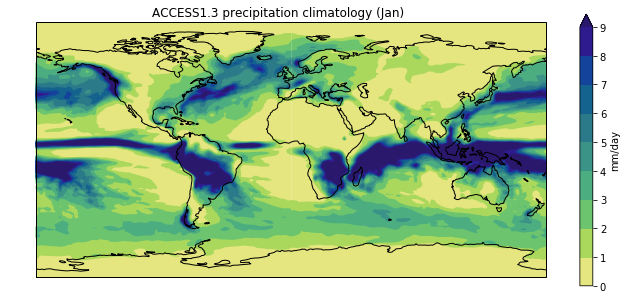

In [4]:
plot_pr_climatology('data/pr_Amon_ACCESS1-3_historical_r1i1p1_200101-200512.nc', 'Jan')
plt.show()

A requirement for our final plot is to apply an ocean mask. To do this, we can use a land surface fraction file.

In [5]:
access_sftlf_file = 'data/sftlf_fx_ACCESS1-3_historical_r0i0p0.nc'

In [6]:
sftlf_cube = iris.load_cube(access_sftlf_file, 'land_area_fraction')
print(sftlf_cube)

land_area_fraction / (%)            (latitude: 145; longitude: 192)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_ACCESS1-3_historical_r0i0p0.nc...
          branch_time: 90945.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          creation_date: 2012-02-15T06:14:44Z
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: fx
          history: 2012-02-15T06:14:43Z altered by CMOR: Converted units from '1' to '%'....
          initialization_method: 0
          institute_id: CSIRO-BOM
          institution: CS

/Users/damienirving/anaconda/envs/pyaos-lesson/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'sftlf'
  warnings.warn(message % (variable_name, nc_var_name))


The data in a sftlf file assigns each grid cell a percentage value between 0% (no land) to 100% (all land).

In [7]:
print(sftlf_cube.data.max())
print(sftlf_cube.data.min())

100.0
0.0


To create a [numpy masked array](https://docs.scipy.org/doc/numpy/reference/maskedarray.html), we need to assign each grid cell a `True` (apply mask) or `False` (do not apply mask) value. For this example, we are going to define the ocean (i.e. the region we want to mask) as any cell that is less than 50% land.

The most obvious solution to creating this mask array might be to loop over each cell in the sftlf array. e.g.

```
nlats, nlons = sftlf_cube.data.shape
mask = numpy.zeros([nlats, nlons])
for y in range(nlats):
    for x in range(nlons):
        if sftlf_cube.data[y, x] < 50:
            mask[y, x] = True
        else:
            mask[y, x] = False
```

While this approach would technically work, the problem is that (a) the code is hard to read, and (b) in contrast to low level languages like Fortran and C, high level languages like Python and Matlab are built for usability (i.e. they make it easy to write concise, readable code) as opposed to speed. This particular array is so small that the looping isn't noticably slow, but in general looping over every data point in an array should be avoided.

Fortunately, there are lots of `numpy` functions that allow you to get around this problem by applying a particular operation to an entire array at once (which is known as a vectorised operation). The `numpy.where` function, for instance, allows us to make a true/false decision at each data point in the array and then perform a different action depending on the answer:

In [8]:
ocean_mask = numpy.where(sftlf_cube.data < 50, True, False)

For a given iris cube (e.g. containing precipitation data from the ACCESS1-3 model), we could then convert the data type to a numpy masked array and apply our ocean mask:

In [9]:
cube = iris.load_cube('data/pr_Amon_ACCESS1-3_historical_r1i1p1_200101-200512.nc', 'precipitation_flux')
print(type(cube.data))

<class 'numpy.ndarray'>


In [10]:
cube.data = numpy.ma.asarray(cube.data)
cube.data.mask = ocean_mask
print(type(cube.data))

<class 'numpy.ma.core.MaskedArray'>


In [11]:
print(cube.data[0, 100:110, 0:10])

[[2.4865681552910246e-05 1.7857040802482516e-05 1.4409809409698937e-05
  1.365557181998156e-05 9.77409854385769e-07 1.6724919760235935e-07 -- --
  -- --]
 [-- 3.080878741457127e-05 2.1845595256309025e-05 2.4051765649346635e-05
  1.7585027308086865e-05 1.6222168142121518e-06 -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [2.005224087042734e-05 -- -- -- -- -- -- -- 3.166760870954022e-05
  1.2054460967192426e-05]
 [1.4890032616676763e-05 -- -- -- -- 2.3196560505311936e-05 -- --
  6.278240471147001e-05 2.7597512598731555e-05]
 [1.0251545063511003e-05 -- -- -- -- 3.0613329727202654e-05 -- --
  2.898933416872751e-05 --]
 [1.4132613614492584e-05 7.409330464724917e-06 -- -- -- -- --
  3.593934889067896e-05 -- --]
 [4.693903247243725e-05 3.182605723850429e-05 1.990660712181125e-05
  8.492984306940343e-06 -- -- 2.465165925968904e-05 -- --
  0.0001078539207810536]
 [6.071893949410878e-05 6.422175647458062e-05 5.667455116054043e-05
  2.7484224119689316e-05 9.198953193845227e-06 1.1014224583050236e

**Challenge:** Create a new function called `mask_ocean()` and insert into `plot_pr_climatology()` so that it reads as follows:
        
```
def plot_pr_climatology(pr_file, sftlf_file, month, cmap=cmocean.cm.haline_r):
    """Plot the precipitation climatology.
    
    Args:
      pr_file (str): Precipitation data file
      sftlf_file (str): Land surface fraction data file
      month (str): Month (3 letter abbreviation, e.g. Jun)
      cmap: matplotlib colormap
    
    """

    cube = read_data(pr_file, month)    
    cube = convert_pr_units(cube)
    clim = cube.collapsed('time', iris.analysis.MEAN)
    
    sftlf_cube = iris.load_cube(sftlf_file, 'land_area_fraction')
    clim = mask_ocean(clim, sftlf_cube)
    
    plot_data(clim, month, cmap)

```

Test to see if your ocean mask worked by plotting the ACCESS1-3 climatology for January:
```
plot_pr_climatology('data/pr_Amon_ACCESS1-3_historical_r1i1p1_200101-200512.nc', 'Jan')
plt.show()

```